### Assignment 2 - _Foundations of Information Retrieval '20/'21_

The second assignment is divided in two parts and it is due before 26/10/2020 (deadline is October 25th at 23:59), via Canvas.
The first part is about _learning-to-rank_ exercises and the use of a ranking-SVM. You will work on an artificially generated data sets of documents. The second part contains small practical image retrieval exercises, using images of a garden.

### Background information
Please study the materials provided with Lecture 5 (for Part 01) and Lecture 6 (for Part 02) to have a solid theoretical base to solve the following exercises. 

To simplify many operations, you can use Python libraries for Machine Learning (for Part 01 and Part 02) and Image Processing (only for Part 02). We advise you to familiarize with:
* [scikit-learn](): library for Machine Learning
* [scikit-image](): library of functions for image processing 
* [matplotlib](): for visualizations and plots

The required libraries are already installed in the virtual machine system.

# Part 01: _Learning-to-rank_

Ranking problems are formulated for data sets that consist of lists of items with some ordering specifications. The order specifications are usually defined by giving a numerical score or a binary judgement (relevant/non-relevant) for each item so that for any two samples `x` and `y`, either `x < y`, `x > y` or `b` and `a` are not comparable. See the lecture material for more details.

### Data set and preparation
In this assignment, you will work with a synthetic data set (with no specific domain) and focus on the methodological aspects of learning-to-rank. 

The data set contains $90$ samples (2-element feature vectors), divided into 45 training and 45 test samples. An ordering rule, defined by given coefficients, is applied to generate the samples in a ranked way and simulate the characteristics of a ranking problem. For each sample in the data set, a target value is specified as a label from the set Y = {0, 1, 2}.

Both training and test set are built in such a way that there are two blocks of data (one initiating in the point (0,0) and another one in the point (-3,-7)), which simulate two lists of documents associated to two different queries.

In the following we provide the code to generate the data (and the train/test split) and to visualize them. Read the code, and eventually explore more deeply the data structures and their content.

In [1]:
import itertools
import numpy as np
from scipy import stats
import pylab as pl
from sklearn import svm, linear_model, model_selection

np.random.seed(0)  # keep the seed to generate the same data set in differente runs of the notebook
theta = np.deg2rad(60)
w = np.array([np.sin(theta), np.cos(theta)])  # coefficients of the direction of the data
K = 90  # indicates the number of samples per target label (total samples = 3 * K)
X = np.random.randn(K, 2)
y = [0] * K
L = 4
for i in range(1, 3):  # samples with different ordering target class are generate along the direction w
    X = np.concatenate((X, np.random.randn(K, 2) + i * L * w))  # feature vectors (2-elements)
    y = np.concatenate((y, [i] * K))  # target label

# Let us have two blocks of data, i.e. drawn from two distributions 
#      [one with origin in (0,0) and the other in (-3,-7)]
# We slightly displace data corresponding to the second block
blocks = np.array([0, 1] * int(X.shape[0] / 2))
X[::2] -= np.array([3, 7]) 

# Split data into train and test set
cv = model_selection.StratifiedShuffleSplit(test_size=.5)
train_index, test_index = next(cv.split(X, y))

X_train, y_train, distID_train = X[train_index], y[train_index], blocks[train_index]
X_test, y_test, distID_test = X[test_index], y[test_index], blocks[test_index]

# Note: we maintain also the information about which block (distribution with a certain center)
#       the samples belong to. This is useful for plots. We cannot use this for training (it is like cheating).

### Visualize the generated data
To have a better idea of the synthetically generated data, we can plot them. 

For visualization purposes, we use different colors to mark the target class, and different marker shapes to indicate the block to which the samples belong, i.e. a triangle for block 1 with origin in (0,0) and a circle to for block 2 with origin in (-3,-7). The blocks refer to the documents associated to query 1 and query 2, respectively.



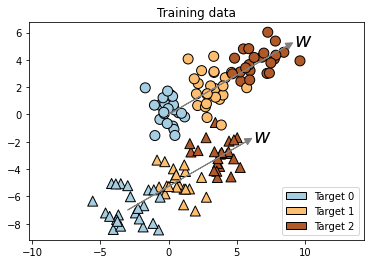

In [2]:
import matplotlib.patches as mpatches

idx = (distID_train == 0)  # select the samples from the first distribution centered in (0,0)
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')


# Plot the training samples
vec_len = 10
pl.arrow(0, 0, vec_len * w[0], vec_len * w[1], 
         fc='gray', ec='gray', 
         head_width=0.5, head_length=0.5)
pl.text(vec_len * w[0] + 0.5, vec_len * w[1], '$w$', fontsize=20)

pl.arrow(-3, -7, vec_len * w[0], vec_len * w[1], 
         fc='gray', ec='gray', 
         head_width=0.5, head_length=0.5)
pl.text(-3 + vec_len * w[0] + 0.5, -7 + vec_len * w[1], '$w$', fontsize=20)


cm = pl.cm.get_cmap('Paired')
pl.legend(loc='lower right',
          handles=[mpatches.Patch(facecolor=cm(0.), edgecolor='k', label='Target 0'),
                  mpatches.Patch(facecolor=cm(0.5), edgecolor='k', label='Target 1'),
                  mpatches.Patch(facecolor=cm(1.), edgecolor='k', label='Target 2'),])

pl.axis('equal')
pl.title('Training data')
pl.show()

It is interesting to notice how for both blocks of data, there is a common vector $w$, that indicates the direction of the ranked objects. If we project the samples onto this vector, we have an ordered list of the documents (note that the vector is the same and indicate a direction onto which we can project the document samples and achieve a ranking - we plot two vectors just to show that the direction is common to both blocks of data).

Thus, using ML techniques to estimate the coefficients of the vector from the training data qialifies as a `learning-to-rank` approach.

> _note:_ we could plot the vector bacause we know the ground truth coefficients $w$, as we used them to generate the data. In a real-world case, you do not know these coefficients and need to estimate them.

## Exercise 01.A: _Pointwise approach - regression-based ranking_

We can implement a regression-based approach to estimate the coefficients of a ranking model (the vector w) and use these coefficients to rank the documents in the test set. We want to learn a model that directly predicts the target label of the test documents, given their feature-vector representation.

Use the fecture vectors in the training set `X_train` (all together - not from the single blocks) and the corresponding labels `y_train` to learn a regression model. Save the estimated coefficients in the variable `coef`, which is used by the visualization code in the following.


> _Hint:_ look into the [Linear Models](https://scikit-learn.org/stable/modules/linear_model.html) class of methods in scikit-learn.
>
> You can try with different linear regression models and compare the results. We provide you with the code for plotting the results. Feel free to modify it, if you need.

In [5]:
# your code here
## BEGIN ANSWER

# Re-shape X_train in order to satisfy input requirements for the linear_model methods.
x_tmp = X_train[:,0].reshape(-1,1)
y_tmp = X_train[:,1].reshape(-1,1)

# Create and fit an OLS linear regression.
lin_reg = linear_model.LinearRegression()
lin_reg.fit(x_tmp, y_tmp)

coef_ols = [0,0]
# In the subsequent cell, we plot the vector w-hat, centred at 0,0.
# Thus, the y-intercept does not matter for now and we are interested only in the direction. 
coef_ols[0] = 1 # the slope given by the regression model gives us the amount y increases for each step of 1 in x 
coef_ols[1] = lin_reg.coef_[0][0]  # Gives us the slope of the fitted line (extract from a single-value array)

intercept_ols = lin_reg.intercept_[0] # Also store the y-intercept for reference.

print('-'*10, "OLS", '-'*20)
print("Equation of line given by: y =", round(coef_ols[1],2), "*x +", round(intercept_ols,2))
print("Coefficients for w-hat:", coef_ols)
print("R^2 OLS:", round(lin_reg.score(x_tmp, y_tmp), 8))


#### Comparing other linear regression techniques. #####
# We can try ridge regression, but it is normally used in more complex models to avoid large weights for many features, 
# and in particular to avoid issues with collinearity between features. 

ridge_mod = linear_model.RidgeCV(alphas=np.logspace(-5,5,11)) # Use cross-validation to find the optimal value for alpha.
ridge_mod.fit(x_tmp, y_tmp)

coef_ridge = [1,0]
coef_ridge[1] = ridge_mod.coef_[0][0]

print('-'*10, "Ridge", '-'*20)
print("Optimal alpha for Ridge regression:",ridge_mod.alpha_)
print("Coefficients for w-hat:", coef_ridge)
print("R^2 Ridge:", round(ridge_mod.score(x_tmp, y_tmp), 8))

# We know that the ground truth value for w = [sin(60), cos(60)], or a vector in the same direction is [1, 1/sqrt(3)]=[1,0.58]
# We could of course increase the size of alpha so that the slope of the ridge model shrinks. However, usually we will not know
# the ground truth, so this is not a good idea. 
# With alpha=1.0 this only slightly reduces the slope.


######## Regression with Loss = Mean Absolute Error  ###############
# Visualising the data, we can see that the fitted linear regression may be impacted by the extreme points
# i.e. those centred around (-3,-7) and the red points at the top-right of the plot.
# Using mean absolute error instead of squared error as the loss function may reduce the influence of these points on the fitted line.
# One way to implement this is using the SGDRegressor method with loss='epsilon_insensitive' and epsilon=0

mae_mod = linear_model.SGDRegressor(loss='epsilon_insensitive', epsilon=0.0, alpha=0.0)
mae_mod.fit(x_tmp,X_train[:,1])

coef_mae = [1,0]
coef_mae[1] = mae_mod.coef_[0] # In fact, this has increased the difference to the ground truth. 

print('-'*10, "MAE", '-'*20)
print("Coefficients for w-hat:", coef_mae) 
print("R^2 MAE:", round(mae_mod.score(x_tmp, y_tmp), 8))

# OLS gives us the best fit for R^2, and ridge regression doesn't signifantly reduce the distance to the ground truth
# so, as per Occam's Razor, let's keep the most simple model.
coef = np.array(coef_ols)
print('-'*40)

## END ANSWER

# Remember to fill in the variable `coef` with the 2 estimated coefficients of the vector. 
# We use the `coef` variable for plotting purposes in the following cell
print("Coefficients for w-hat:", coef)

---------- OLS --------------------
Equation of line given by: y = 0.86 *x + -3.02
Coefficients for w-hat: [1, 0.8600014293641912]
R^2 OLS: 0.49034702
---------- Ridge --------------------
Optimal alpha for Ridge regression: 1.0
Coefficients for w-hat: [1, 0.8593818846679921]
R^2 Ridge: 0.49034677
---------- MAE --------------------
Coefficients for w-hat: [1, 0.9148759690441698]
R^2 MAE: 0.46844488
----------------------------------------
Coefficients for w-hat: [1.         0.86000143]


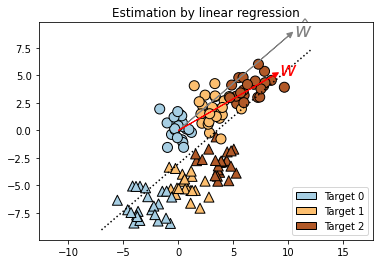

In [6]:
# Plot the training samples and the estimated ranking model (vector w)
# NOTE: we use the block indices (idx and ~idx) computed before only for a visualization purpose
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# plot estimated coefficient vector
pl.arrow(0, 0, vec_len * coef[0], vec_len * coef[1], 
         fc='gray', ec='gray', head_width=0.5, head_length=0.5)
pl.text(vec_len * coef[0] + 0.5, vec_len * coef[1], '$\hat{w}$', fontsize=20, fontdict={'color': 'gray'})

# plot ground truth coefficients (those used for data generation)
pl.arrow(0, 0, vec_len * w[0], vec_len * w[1], 
         fc='red', ec='red', head_width=0.5, head_length=0.5)
pl.text(vec_len * w[0] + 0.5, vec_len * w[1], '$w$', fontsize=20, fontdict={'color': 'red'})

# Plot fitted line from linear regression for reference
x_pts = np.linspace(-7,12, 100)
y_pts = x_pts*coef[1] + intercept_ols
pl.plot(x_pts, y_pts, ":k")


pl.axis('equal')
pl.title('Estimation by linear regression')

cm = pl.cm.get_cmap('Paired')
pl.legend(loc='lower right',
          handles=[mpatches.Patch(facecolor=cm(0.), edgecolor='k', label='Target 0'),
                  mpatches.Patch(facecolor=cm(0.5), edgecolor='k', label='Target 1'),
                  mpatches.Patch(facecolor=cm(1.), edgecolor='k', label='Target 2'),])

pl.show()

In the previous plot, the red vector $w$ indicates the ground truth direction that we should aim at estimate (which in our case provides the optimal ranking according to the relevance judgements). The grey vector $\hat{w}$ is the result of the estimation using a regression-based approach. The should point at different direction, meaning that the regression-based approach may not provide the best results. That's why we can look into more complicated (ML-based) approaches.

## Exercise 01.B: _performance of regression-based ranking (Kendall's Tau)_

Evaluate the performance of the learned model by using it to rank the test set and comparing it to the target labels.
As the problem you are working with is a ranking problem, you need to use a measure of performance that is based on a ranking score, that is you need to compare the _order_ of the retrieved documents by your model with the _order_ of the groud truth data.

In the lecture, we have seen that the [Kendall's tau correlation coefficient](http://en.wikipedia.org/wiki/Kendall_tau_rank_correlation_coefficient) is a measure of the quality of data ordering with respect to a given ground truth ordering. It is defined as (P - Q)/(P + Q), where P is the number of concordant pairs and Q is the number of discordant pairs.

Implement the code to compute the Kendall's Tau on the ranking order that you obtain by applying your regression model to the documents in the test set `X_test` with labels `y_test`. 
It is reasonable to evaluate the results obtained for each query independently, thus you can compute the Kendall's tau ranking score independently for the documents in block 1 and 2 of the test data.

> Look into [Scipy's Stats library](https://docs.scipy.org/doc/scipy/reference/stats.html) for hints on how to compute the [Kendall's tau](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau). 

In [7]:
## BEGIN ANSWER
# For each block, we need to calculate the projection of each point onto w and onto w-hat. 
# We then need to take all possible pairs of documents within each block, and compare the order given by each projection.
# We can use the Scipy Stats implementation of Kendall's tau to do this second step.

# Global ranking
true_order = [w.dot(x) for x in X_test]
pred_order = [coef.dot(x) for x in X_test]

tau_global, p_global = stats.kendalltau(true_order, pred_order)

# Block 1
true_order_1 = [w.dot(x) for x in X_test[distID_test==0]]
pred_order_1 = [coef.dot(x) for x in X_test[distID_test==0]]
tau_1, p_1 = stats.kendalltau(true_order_1, pred_order_1)
# Block 2
true_order_2 = [w.dot(x) for x in X_test[distID_test==1]]
pred_order_2 = [coef.dot(x) for x in X_test[distID_test==1]]
tau_2, p_2 = stats.kendalltau(true_order_2, pred_order_2)

print('p-values:', p_global, p_1, p_2) 
# p-value < 0.05 for all cases, so we reject the null hypothesis that there is no relationship between the rankings
# We expect this, of course, given the large tau values.

# There is a very high correlation between the ground truth rankings and the predicted rankings based on OLS regression.
# However, there is still room for improvement to get this closer to 1.
# The correlation is a bit better for block 2.       

# To further evaluate this method, we could implement some thresholds along the projections onto w-hat 
#  in order to group the points into different classes and compare to the target values.

## END ANSWER

print('Kendall correlation coefficient: %.5f' % (tau_global))
print('Kendall correlation coefficient Block 1: %.5f' % (tau_1))
print('Kendall correlation coefficient Block 2: %.5f' % (tau_2))

p-values: 1.8364600800484313e-60 3.5614959988491256e-31 1.0898422744447439e-30
Kendall correlation coefficient: 0.95334
Kendall correlation coefficient Block 1: 0.95567
Kendall correlation coefficient Block 2: 0.97016


## Classifiers for ranking problems 

A ranking problem can be transformed into a classification problem by manipulating the training data (feature vectors and ordinal labels). One can transform the training data by computing all the pairwise differences of the feature vectors $x_i$ and corresponding labels $y_i$ as:

$(\mathbf{x'_k}, y'_k) = \left(\mathbf{x_i} - \mathbf{x_j}, sign(y_i - y_j)\right)$

In the case we have $N$ documents (represented by $N$ feature vectors), the pairwise transformed data will be composed by $N(N-1)/2$ feature vectors (and corresponding labels). In this way, the input training data with multiple ordinal targets are transformed into a two-class data set, suitable for linear classification algorithms.

## Exercise 01.C: _pairwise transform_
Implement the code to perform a pairwise transfor of the training data. As seen in the lecture, the pairwise transform translates your dataset of single documents (with labels) into a dataset of pairs of documents (with labels related to the pairs - see Lecture 05 slides). You will use (in later parts of the assignment) the dataset that results from the pairwise transformation to train a ranking model.

Here, implement the code to perform the pairwise transform of the training data.

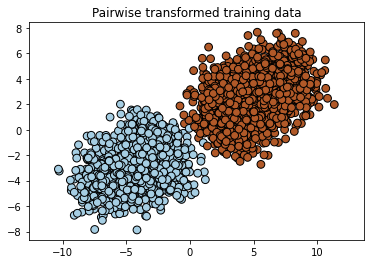

In [8]:
# your code here
## BEGIN ANSWER

x_diff = np.zeros(shape=(len(X_train)*len(X_train), 2))
y_sign = np.zeros(shape=(len(X_train)*len(X_train), 1))

count = 0
for i in range(len(X_train)):
    for j in range(len(X_train)):
        # If it's the same document, a document from a different block or the target is the same, then skip this iteration.
        if i >= j or distID_train[i] != distID_train[j] or y_train[i] == y_train[j]:
            count += 1
            continue
        x_diff[count,:] = X_train[i] - X_train[j]
        y_sign[count] = np.sign(y_train[i]-y_train[j])
        count +=1

cond = [y[0] != 0 for y in y_sign]
X_pw = x_diff[cond,]
y_pw = y_sign[cond,]

## END ANSWER


# Plot the transformed data set 
# (note that the number of points -- documents -- increases 
# due to the all the pairwise combination of documents)    

# We use X_pw and y_pw to indicate the transformed data points and the corresponding labels, respectively
pl.scatter(X_pw[:, 0], X_pw[:, 1], c=y_pw, s=60, 
           marker='o', edgecolors='k', cmap=pl.cm.Paired)

x_space = np.linspace(-10, 10)
# pl.plot(x_space * w[1], - x_space * w[0], color='gray')  # this is the expected separation plane (from the ground truth coefficients)
# pl.text(3, -4, '$\{x^T w = 0\}$', fontsize=17)
pl.axis('equal')
pl.title('Pairwise transformed training data')
pl.show()


## Exercise 01.D: _ranking SVM_

Before you work on training the ranking SVM model, check that the plot of your pairwise-transformed data looks like the one plotted by the following code. 
It loads a previously created data set, that you can use as your reference to check that your transformation is correctly implemented.

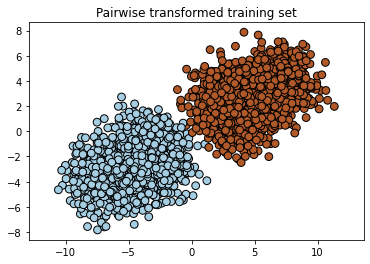

In [9]:
import pickle
f = open('data02/pairwise-dataK90.bin', 'rb')
data = pickle.load(f)
f.close()

X_pw = data.get('X')
y_pw = data.get('y')

# plot
pl.scatter(X_pw[:, 0], X_pw[:, 1], c=y_pw, s=60, 
           marker='o', edgecolors='k', cmap=pl.cm.Paired)

#x_space = np.linspace(-10, 10)
#pl.plot(x_space * w[1], - x_space * w[0], color='gray')  # this is the expected separation plane (from the ground truth coefficients)
# pl.text(3, -4, '$\{x^T w = 0\}$', fontsize=17)
pl.axis('equal')
pl.title('Pairwise transformed training set')
pl.show()


### SVM implementation

This classification problem looks (almost) linearly separable, i.e. a line can be drawn that separates the two sets of document pair points. This is not always the case (for instance, you can change the data generation code, parameter L, and generate differently spaced data, which may not be linearly separable after pairwise transformation - you can still use an SVM then, allowing for errors).

Write the code to train a ranking SVM model on the pairwise transformed data. The model will estimate the coefficients of the vector $\hat{w}$, which you can use to rank the test documents as explained above.

Study the SVM from the lecture materials and from [online resources](https://en.wikipedia.org/wiki/Support_vector_machine).
Read the documentation of the [Scikit-learn SVM package](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (the attribute `coef_` will turn to be useful).

> _Hint:_ explore the impact of parameter C of the SVM on the classification results. Look into the generalization capabilities of the model.
>
> We provide the code for generation of the plot. If you need, you can modify it.

In [24]:
test = np.array([[1,2]])
test[0]

array([1, 2])

Estimated coefficients: [0.3804005994441954, 0.2247037055371008]
vector directions:
linear regression: [1,0.86], ground truth: [1,0.58], SVM: [1,0.591]


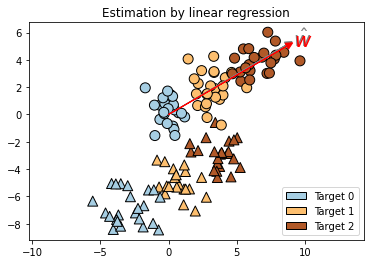

In [49]:
# your code here
## BEGIN ANSWER

linear_svm = svm.SVC(kernel='linear', C= 0.001)

linear_svm.fit(X_pw, y_pw)

coef = linear_svm.coef_.tolist()[0]
print("Estimated coefficients:", coef)

# Get the unit vector in the same direction.
coef /= np.sqrt(coef[0]*coef[0] + coef[1]*coef[1])

print('vector directions:\nlinear regression: [1,0.86], ground truth: [1,0.58], SVM: [1,%.3f]' % (coef[1]/coef[0]))
## END ANSWER

# plot the training data and the coefficient vector 
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# plot estimated coefficient vector
pl.arrow(0, 0, vec_len * coef[0], vec_len * coef[1], 
         fc='gray', ec='gray', head_width=0.5, head_length=0.5)
pl.text(vec_len * coef[0] + 0.5, vec_len * coef[1], '$\hat{w}$', fontsize=20, fontdict={'color': 'gray'})

# plot ground truth coefficients (those used for data generation)
pl.arrow(0, 0, vec_len * w[0], vec_len * w[1], 
         fc='red', ec='red', head_width=0.5, head_length=0.5)
pl.text(vec_len * w[0] + 0.5, vec_len * w[1], '$w$', fontsize=20, fontdict={'color': 'red'})

pl.axis('equal')
pl.title('Estimation by linear regression')

cm = pl.cm.get_cmap('Paired')
pl.legend(loc='lower right',
          handles=[mpatches.Patch(facecolor=cm(0.), edgecolor='k', label='Target 0'),
                  mpatches.Patch(facecolor=cm(0.5), edgecolor='k', label='Target 1'),
                  mpatches.Patch(facecolor=cm(1.), edgecolor='k', label='Target 2'),])

pl.show()


The estimated coefficient vector $\hat{w}$ is more similar to $w$ (exact vector used for data generation) than that estimated using linear regression models? Is this a good result (looking at generalization)? Think about it.

## Exercise 01.E: _performance of ranking SVM_

Evaluate the Kendall's Tau score of the ranking SVM Model applied to the test documents, similarly to exercise 01.B. Compare the results and make your own observations (you can write them as comments in the cell below, or you can create a new cell).

> Note that the SVM predicts a binary class, which will contrast with the ordinal prediction required to compute the Kendall's tau. You should thus use the vector of coefficients learned by the ranking SVM to perform the projections of the test samples and obtain an ordinal categorization. To perform the projection operation you may want to use the [NumPy dot product function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html).

In [50]:
# your code here
## BEGIN ANSWER
# Global ranking
pred_order = [coef.dot(x) for x in X_test]

tau_global, p_global = stats.kendalltau(true_order, pred_order)

# Block 1
pred_order_1 = [coef.dot(x) for x in X_test[distID_test==0]]
tau_1, p_1 = stats.kendalltau(true_order_1, pred_order_1)
# Block 2
pred_order_2 = [coef.dot(x) for x in X_test[distID_test==1]]
tau_2, p_2 = stats.kendalltau(true_order_2, pred_order_2)

print('Kendall correlation coefficient: %.5f' % (tau_global))
print('Kendall correlation coefficient Block 1: %.5f' % (tau_1))
print('Kendall correlation coefficient Block 2: %.5f' % (tau_2))
## END ANSWER

Kendall correlation coefficient: 0.99735
Kendall correlation coefficient Block 1: 0.99659
Kendall correlation coefficient Block 2: 0.99907


# Part 02: Image Retrieval

_You are suggested to work on this part after Lecture 06 (Multimedia Information Retrieval - Image Retrieval)_

In the second part of the assignment, you will work on a simple image retrieval problem, and implement parts of the Bag Of Words retrieval approach. You will work with images from the [http://www.trimbot2020org](TrimBot2020 project), which aimed at constructing the first outdoor gardening robot. For a robot it is important to retrieve from a map or reference set of images the most similar images to what is being recording with a camera, in order to recognize a preivously visited place.

You are asked to retrieve, from a collection of garden images, the most similar images to given queries. For this, we provide you a dataset, composed of:

* _map/_ folder: contains 100 images used as map (document collection)
* _query/_ folder: contains 100 images used as queries
* _map.json_: list of images included in the map (the order is important because it correspond to the orded in the similarity matrix - see below)
* _query.json_: list of images used for query (the order is important because it correspond to the orded in the similarity matrix - see below)
* _gt.h5_: matrix of image similarity, containts all the information about relevant/non-relevant images 

__Relevance judgements (in the form of a matrix, the structure of which is explained below)__
For each query image, we provide a specification of which map images are relevant (1 in the gt.h5 file) and which are not (0 in the gt.h5). The content of the gt.h5 file is a matrix, with rows corresponding to query images and columns corresponding to the map images. The matrix has thus has $N=100$ rows (where $N$ is the number of query images in the folder `query/`) and $M=100$ columns (where $M$ is the number of query images in the folder `map/`). 

The $i$-th row of the matrix thus contains the relevance judgement for the $i$-th query image with respect to the map images. 
For instance, row 5 of the matrix is a vector of 100 elements (one for each image in the map), in which each element is 1 if the corresponding map image is relevant for the query image 5, or $0$ in case it is not relevant.

Please note that in Python the index of a vector (or matrix) starts from 0 (instead of 1). This means that the first element of a vector has index $0$, and that, for example, the element with index $25$ corresponds to the 26-th element of the vector. 
Thus, as an example, the cell $(10, 25)$ contains the relevance of the 26-th map image for the $11$-th query image (i.e. is the 26-th image in the map relevan (1) or not (0) for the query image number 11?).
 

In the following, we provide you the code for loading the data set and to visualize the images.


## Load the query and map images
In the following we load the list of images in the map set (collection) and in the query set.
For each image, we have information also about the absolute coordinates of the camera that took the picture in the garden environment. _Do not consider these coordinates for the exercises. We use them only to show the trajectory followed by the robot taking the pictures (see below)._ 

In [4]:
# install the library h5py (needed to load and read the ground truth relevance feedback file)
!pip3 install h5py

  Using cached https://files.pythonhosted.org/packages/60/06/cafdd44889200e5438b897388f3075b52a8ef01f28a17366d91de0fa2d05/h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b8/e5/a64ef44a85397ba3c377f6be9c02f3cb3e18023f8c89850dd319e7945521/numpy-1.19.2-cp36-cp36m-manylinux1_x86_64.whl


In [1]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt

with open("data02/map.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_poses=np.array(m_idx["poses"])
with open("data02/query.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_poses=np.array(q_idx["poses"])

In /home/atlantis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/atlantis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/atlantis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/atlantis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/atlantis/.local/lib/python3.6/site-packages/matplotlib/

### Visualization of robot trajectories
The pictures in the map (collection) and query sets have been recorded by a robot that navigates in the garden enviroment where it has to be localized. When recording the map images, the robot followed the blue trajectory (run the code below), while it followed the orange trajectory while recording the query images.

You can notice how the blue and orange trajectories overlap partially. In that overlapping area, the query images will have some relevant images among the map images. Conversely, in the areas there there is no overlap (and the points are not even close), the map images will be non-relevant for the query images. 
Please read more details in the next sections, where the ground truth relevance judgements are provided and explained.

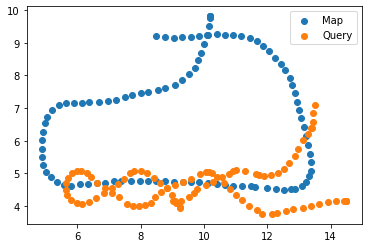

In [28]:
plt.scatter(m_poses[:,0],m_poses[:,1], label="Map")
plt.scatter(q_poses[:,0],q_poses[:,1], label="Query")
plt.legend()

## Load the similarity matrix (relevance judgements)

The gt.h5 file contains two sets of relevance  judgements, specified by the keys `sim` and `fov`.
`sim` specifies it in the form 0/1 (non-relevant/relevant).
`fov` (that stands for field of view) specifies it as a degree of similarity, a value defined in the interval $[0, 1]$ that indicates how much the query and map images are similar. We do not use it for this assignment, but you may consider it when working on the final project.


In [3]:
# loading the relevance judgements
with h5py.File("data02/gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

We use the matrix with binary relevance judgements `sim` in this assignment. 
To obtain the relevance judgement of the map image 'map_id' for the query 'query_id', you  can use the syntax `sim[query_id, map_id]`. 

In the following we show few examples:

In [4]:
print('Relevance of the 10th map image for the 5th query image: ', sim[4, 9])
# note that for the 10th map image we have to access column 10-1=9
# similarly for the 5th query image we access column 5-1=4
print('Relevance of the 60th map image for the 87th query image: ', sim[86, 60])

Relevance of the 10th map image for the 5th query image:  0
Relevance of the 60th map image for the 87th query image:  1


### Visualization of random images. 
For a given query image, we select one relevant and one non-relevant result image from the map.
See below:

(-0.5, 751.5, 479.5, -0.5)

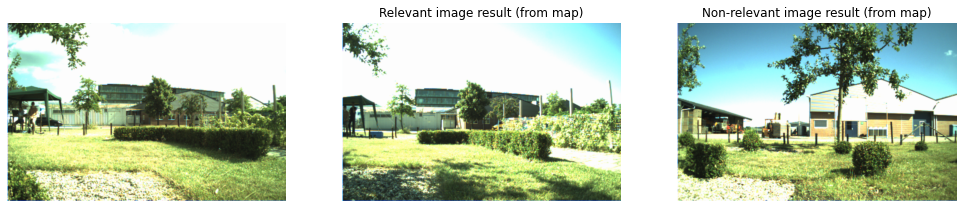

In [5]:
# generate random index for the query image
# You can try with it (but in the case a query image does not have relevant results in the map, the code will give an error)
# query_idx = np.random.randint(0, 99) 

# For visualization purposes, we select a query image for which there are relevant and non-relevant results in the collection (map)
query_idx = 86

# select the relevant and non-relevant map images for the randomly selected query image
rel = np.where(sim[query_idx, :] == 1)
nonrel = np.where(sim[query_idx, :] == 0)


# randomly select a relevant and non-relevant image
rel_idx = rel[0][np.random.randint(0, len(rel[0]) - 1)]
nonrel_idx = nonrel[0][np.random.randint(0, len(nonrel[0]) - 1)]

plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread("data02/" + q_imgs[query_idx]))
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Relevant image result (from map)')
plt.imshow(plt.imread("data02/" + m_imgs[rel_idx]))
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Non-relevant image result (from map)')
plt.imshow(plt.imread("data02/" + m_imgs[nonrel_idx]))
plt.axis("off")



If you want to collect all relevance judgement for the $i$th query image, you need to access the $(i-1)$th row of the matrix `sim`. To visualize the relevance judgment you have to loop over the accesses vector (a row of a matrix is a vector.

In the following an example of how to do that.

In [6]:
# accessing (and printing out) the relevance judgement for the query image number 87

query_id = 86  # 87-1
for idx in range(len(sim[query_id, :])):
    # idx is the index of the vector. It corresponds to the map image index
    # rel contains the relevance (0/1) of the idx-th map image for the considered query image (9th image in our case)
    print("Relevance of the %d-th map image for the 9-th query image: %d" % (idx, sim[query_id, idx]))

Relevance of the 0-th map image for the 9-th query image: 0
Relevance of the 1-th map image for the 9-th query image: 0
Relevance of the 2-th map image for the 9-th query image: 0
Relevance of the 3-th map image for the 9-th query image: 0
Relevance of the 4-th map image for the 9-th query image: 0
Relevance of the 5-th map image for the 9-th query image: 0
Relevance of the 6-th map image for the 9-th query image: 0
Relevance of the 7-th map image for the 9-th query image: 0
Relevance of the 8-th map image for the 9-th query image: 0
Relevance of the 9-th map image for the 9-th query image: 0
Relevance of the 10-th map image for the 9-th query image: 0
Relevance of the 11-th map image for the 9-th query image: 0
Relevance of the 12-th map image for the 9-th query image: 0
Relevance of the 13-th map image for the 9-th query image: 0
Relevance of the 14-th map image for the 9-th query image: 0
Relevance of the 15-th map image for the 9-th query image: 0
Relevance of the 16-th map image f

## ASSIGNMENT: Bag of Words representation
As seen in the lecture, in order to construct a dictionary of 'visual' terms (words) from a collection of images, one can extract local features from the images (e.g. keypoints) and use a clustering algorithm to automatically find groups (i.e. clusters) of similar local features. The centroid of a cluster is also a feature vector and can be considered as a term to be used for the search and retrieval of similar images.

In this assignment, we use the [$K$-Means clustering algorithm](https://www.youtube.com/watch?v=_aWzGGNrcic) (where $k$ is defined as a parameter by us) to extract the visual dictionary of terms from the images in the map collection (in the cells below you will find more information).

In the following code (please study it), we:
* load the list of images in the map collection
* for each image we extract a maximum of 200 ORB keypoints (local keypoint features). Each keypoint is described by a vector of 128 elements (keypoint descriptor) that describes the local characteristics of the image.
* use the set of keypoint descriptors (200 keypoints * 100 images = 20000 vectors) as input of the k-Means clustering algorithm
* compute k=100 cluster centroids (which correspond to the 100 terms of our dictionary)

> __Note:__ Please, find more information about ORB in the [ORB paper](https://ieeexplore.ieee.org/document/6126544) and in the [Scikit Image ORB documentation](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html).

> __Note 2:__ it may take some time to extract the descriptors from all images.

In [50]:
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray

# Initialize the ORB descriptor
descriptor_extractor = ORB(n_keypoints=200)
# Initialize the data structure that will contain all the descriptors
descriptors = None

# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
    #print(descriptors.shape)
    
# We have extracted 200 descriptors per image, for 100 images. The ORB descriptors have length 256
print(descriptors.shape)

(20000, 256)


## Clustering
Following the Bag of Words framework (see the slides of the lecture), we can define the basic 'words' that compose the images via a clustering algorithm that takes the descriptors of the map images (training) as input. The basic 'words' form a so called visual vocabulary and are learned by grouping together those descriptor vectors that are most similar, i.e. their distance is lower than that between other descriptors.

We do it by using the $K$-Means algorithm: find [here](https://en.wikipedia.org/wiki/K-means_clustering) some more information about KMeans and [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) the reference documentation of the algorithm in Scikit-learn. Also an explanatory video with examples [here](https://www.youtube.com/watch?v=_aWzGGNrcic).


In [8]:
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 100  # number of clusters (equivalent to the number of words) we want to estimate
kmeans = KMeans(n_clusters=K, random_state=0, n_init=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images


Shape of the centroids matrix:  (100, 256)
We computed  100 centroids of lengh  256  (the same of the descriptor)


## Exercise 02.A: _'Bag of words' vector computation_

In order to compute the BoW representation of an image, we have to count the occurrences of the visual 'words', i.e. the local features, that we have learned in our visual vocabulary (using the $K$-Means clustering).

Given an image, we do the following:
   * we extract the local descriptors (we are using ORB descriptors in this assignment) 
   * for each descriptor we find the closest 'word' (i.e. the closes cluster centroid) in the visual vocabulary
   * we sum +1 to the counting of the occurence of the 'word' (in this way we construct the histogram of the occurrence of the visual 'words')
    
An image is thus described with a vector (of $K$ elements) that is an histogram of the occurrence of the words in the learned visual vocabulary (similar to the occurrence of words in a text document).  

In the following, implement the core of the function that computes the BoW vector. The function takes as input the centroids of the learned clusters (i.e. the vocabulary of the visual words) and the set of descriptors extracted from an image. It must return the BoW vector.

In [107]:
# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for n in range(n_descriptors):
        similarities = [np.sum(np.square(img_descriptors[n]-centroid)) for centroid in centroids]
        best = np.argmin(similarities)
        bow_vector[best] += 1
        
        
    return bow_vector


# Test the implementation of the BoW vector computation
img = plt.imread(os.path.join('data02/', q_imgs[0]))
img = rgb2gray(img)

descriptor_extractor.detect_and_extract(img)  
# keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
query_img_descriptors = descriptor_extractor.descriptors 

bow = bag_of_words(centroids, query_img_descriptors)
print("Size of the bow vector: ", bow.shape)
print("Bow vector: ", bow)


Size of the bow vector:  (100,)
Bow vector:  [ 4.  2.  4.  0.  1.  6.  0.  0.  0.  0.  4.  1.  1.  0.  0.  6.  0.  4.
  4.  5.  1.  1.  4.  0.  0.  0.  3.  0.  1.  1.  2.  0.  1.  1.  1.  3.
  1.  1.  5.  0.  3.  1.  2.  4.  4.  0.  1.  2.  3.  1.  2.  2.  1.  0.
  5.  8.  2.  4.  0.  0.  5.  2. 11.  3.  0.  1.  1.  1.  1.  3.  5.  2.
  3.  3.  0.  2.  4.  1. 10.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  2.
  3.  3.  3.  0.  0.  3.  1.  1.  4.  3.]


### Bag of words representation of the map images 
Given a query image, our aim is to find similar images in our collection (i.e. map) images.
To do that, we have to convert the query image into its Bag of words (BoW) representation and look for similar vectors in the collection (i.e. map) images.

At this stage, since we will do many queries, it is handy to compute the BoW vectors for all images in the collection (i.e. map) and reuse them for multiple queries. (We convert all images in the collection to their BoW representation).

> It is advised to study and understand the code below.

> It may take some time to run the code below.

In [63]:
bow_map_images = None
# loop over the images in the map set
for img_name in m_imgs:
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (200 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroinds, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)
(200, 256)
(100, 256)

At this point, the 100 images in the map have been converted into their BoW representation. The data structure has size $NxK$, where $N=100$ is the number of map images, while $K=100$ is the number of basic 'words' of the BoW representation.



In [64]:
print(bow_map_images.shape)

(100, 100)


## Exercise 02B: _Retrieve images_
We are ready to retrieve images from the collection (i.e. map) images, given the BoW representation of a query image. In order to do that, compute the Euclidean distance between the BoW vector of the query image and the BoW vector of all the collection images and return those with the smaller distance. 

_Hint:_ after computing the distances between the query image BoW vector and all BoW vectors of the map image, you may want to sort them in ascending order; the Numpy function [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) may turn out to be useful.

> For this exercise you are asked to compute the Euclidean distance, but other distance metrics can also be used, e.g. Cosine distance, Minkowski Distance, Manhattan distance, etc. (this is left to you, if you want to explore them as well)

In [135]:
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
def retrieve_images(map_bow_vectors, query_bow):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  # use this to
    distances = np.array([np.sum(np.square(query_bow-map_bow_vectors[n])) for n in range(n_map_bow_vectors)])
    most_similar = np.argsort(distances)
    return most_similar[:10]



# Retrieve the most similar images to query image 87 (index 87-1=86)
query_idx = 86
img = plt.imread("data02/" + q_imgs[query_idx])
img = rgb2gray(img)
# compute bag of words
descriptor_extractor.detect_and_extract(img)  
query_img_descriptors = descriptor_extractor.descriptors 
bow = bag_of_words(centroids, query_img_descriptors)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images = retrieve_images(bow_map_images, bow)
print('Indices of similar images retrieved: ', retrieved_images)
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[86, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

Indices of similar images retrieved:  [61 38 52 63 57 69 48 29 51 72]
Indices of relevant images (given in the GT relevance judgements):  [59 60 61 62 63 65 66 67]


## Exercise 02.C: _evaluation of performance_
As now you are able to retrieve images from the map that are similar (according to the BoW framework) to query images, you should evaluate the performance.

Use the `precision_at_k()` function that you have developed for Assignment 01 (on text retrieval) and compute the precision@5 and precision@10 for the retrieval results of the previous exercise (`retrieved_images`).

In [124]:
### COPIED CODE FROM SUBMISSION 1
def precision(relevant, retrieved):
    if len(retrieved) == 0:
        return 0
    
    if len(relevant) == 0:
        return 1
    
    relevant_and_retrieved = [k for k in retrieved if k in relevant]
    return len(relevant_and_retrieved) / len(retrieved)

def precision_at_k(relevant, retrieved, k):
    return precision(relevant, retrieved[:k])


In [136]:
print(retrieved_images)
print(relevant_images)

retrieved_images = list(retrieved_images)
relevant_images = list(relevant_images)

prec5 = precision_at_k(relevant_images, retrieved_images, 5)
prec10 = precision_at_k(relevant_images, retrieved_images, 10)

print('P@5: ', prec5)
print('P@10: ', prec10)

[61 38 52 63 57 69 48 29 51 72]
[59 60 61 62 63 65 66 67]
P@5:  0.4
P@10:  0.2


## Exercise 02.D (Bonus): _overall performance evaluation_
Extend the previous exercise by computing the Mean Average Precision (MAP) for the whole set of 100 query images.

__Note:__ Implementation of this exercise is completely on your own, without a given code structure, but try to reuse as much as possible the code already available.


In [121]:
### COPIED CODE FROM SUBMISSION 1

def average_precision(relevant, retrieved):
    # Initialise list of precisions with a zero for each relevant document.
    if len(relevant) == 0:
        return np.NAN
    
    P = [0] * len(relevant)
    
    for i, doc in enumerate(relevant):
        # If a relevant document is not retrieved, the precision value is taken to be zero. 
        if doc not in retrieved:
            P[i] = 0
        else:
            # Find the precision for the top k documents when doc is retrieved.
            k = retrieved.index(doc)
            print(relevant, retrieved, k)
            P[i] = precision_at_k(relevant, retrieved, k)
    
    # Return the average precision
    return sum(P)/len(P)


In [122]:
def query(n):
    ''' returns relevant, retrieved   '''
    img = plt.imread("data02/" + q_imgs[n])
    img = rgb2gray(img)
    # compute bag of words
    descriptor_extractor.detect_and_extract(img)  
    query_img_descriptors = descriptor_extractor.descriptors 
    bow = bag_of_words(centroids, query_img_descriptors)

    # Retrieve the indices of the top-10 similar images from the map
    return list(np.where(sim[n, :] == 1)[0]), list(retrieve_images(bow_map_images, bow))

avg_prec = [] 
for n in range(100):
    print(n)
    rel, ret = query(n)
    print(rel, ret)
    prec = average_precision(rel, ret)
    print(prec)
    avg_prec.append(prec)
print(avg_prec)

0
[] [51, 7, 10, 90, 78, 79, 48, 72, 18, 54]
nan
1
[] [51, 78, 90, 48, 10, 72, 18, 7, 17, 41]
nan
2
[] [51, 41, 79, 48, 18, 26, 78, 72, 7, 17]
nan
3
[] [51, 7, 10, 90, 17, 18, 72, 48, 78, 41]
nan
4
[] [51, 73, 48, 42, 64, 17, 67, 50, 54, 72]
nan
5
[] [10, 42, 17, 41, 7, 48, 72, 44, 16, 18]
nan
6
[] [71, 73, 44, 72, 29, 52, 69, 49, 63, 64]
nan
7
[] [41, 69, 48, 71, 49, 73, 42, 76, 72, 57]
nan
8
[] [73, 64, 92, 90, 57, 93, 42, 76, 41, 51]
nan
9
[] [41, 71, 57, 72, 64, 73, 86, 92, 13, 67]
nan
10
[] [73, 72, 89, 77, 88, 69, 90, 92, 74, 91]
nan
11
[] [64, 66, 72, 55, 37, 71, 62, 63, 74, 31]
nan
12
[] [66, 93, 49, 54, 67, 92, 46, 56, 68, 58]
nan
13
[] [71, 72, 75, 90, 79, 10, 88, 78, 93, 74]
nan
14
[] [66, 51, 41, 42, 64, 18, 49, 26, 67, 48]
nan
15
[] [47, 93, 54, 5, 66, 48, 73, 86, 51, 49]
nan
16
[] [73, 67, 54, 49, 52, 86, 64, 51, 37, 46]
nan
17
[] [37, 38, 42, 66, 33, 73, 46, 71, 48, 50]
nan
18
[] [29, 54, 33, 72, 45, 38, 37, 32, 71, 36]
nan
19
[] [47, 51, 37, 31, 33, 42, 29, 52, 45, 44]


In [139]:
avg_prec = np.array(avg_prec)

print(np.nanmean(avg_prec))

0.009736000881834213
